In [1]:
import pandas as pd
import numpy as np
import janitor
import unidecode
import pickle
import os
import operator
import functools
import itertools
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Callable
from matplotlib.collections import EllipseCollection
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.cluster import KMeans

from quickstart.loader import XlsxDriveLoader

%matplotlib inline


In [2]:
Loads = XlsxDriveLoader()  # Drive Folder is hardcoded in module, since this is not prone to change
databases = Loads.content  # Process takes approximately ~3 minutes to run for the first time.


Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?client_id=438184844244-uhk0l93iq5rfack31hmfbp1ted62o9o3.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=offline&response_type=code

Authentication successful.
Data was correctly allocated in memory


# Preparación

In [3]:
(db_name_anotaciones, db_name_meteoorologicas,
 db_name_meteoorologicas, db_name_contaminantes) = databases.keys()


get_col_names: Callable[[pd.core.frame.DataFrame], pd.core.indexes.base.Index] = (
    lambda df: sorted(list(df.columns)))


def shared_structure(db_name: str) -> list:
    """Returns sheets in dict of DataFrames that conain the same fields"""

    df_col_names = [[key, get_col_names(val)]
                        for key, val in databases[db_name].items()]

    grouped = list()
    for _, g in itertools.groupby(df_col_names, operator.itemgetter(1)):
        group = list(g)
        if len(group) > 1:  # Can't be performed with comprehension since g is a generator/iterator
            grouped.append(group)

    if len(grouped) == 1:
        return [sheet_name for sheet_name, _ in functools.reduce(operator.iconcat, grouped, [])]
        # Expecting there is only one shared_structure across the DataFrames
    else:
        return ...  # Not necessary


In [4]:
raw_contaminantes = pd.concat([databases[db_name_contaminantes][sheet]
                               for sheet in shared_structure(db_name_contaminantes)])

raw_meteorologicas = pd.concat([databases[db_name_meteoorologicas][sheet]
                                for sheet in shared_structure(db_name_meteoorologicas)])


In [5]:
# Dictionary for categorical values

identifier = (
    databases[db_name_anotaciones]['LEEME']
    .loc[:, ['Flag', 'Hora']]
    .set_index('Flag')
    .dropna(axis='index')
    .squeeze()
    .apply(lambda string: unidecode.unidecode(string).strip().lower())
    .apply(lambda validity: True if validity == 'valida' else False)
    .to_dict()
)

identifier |= {'x': False}  # Record does not appear on DataFrame


def f_identifier(dict_): return identifier.get(dict_, True)

# Dictionary for mesaurement units

measurement_units = (
    databases[db_name_anotaciones]['Hoja1']
    .iloc[23:41, [0, 2]]
    .dropna()
    .drop(33)
    .pivot(columns='Notas a considerar:', values='Unnamed: 2')
    .pipe(janitor.clean_names, remove_special=True)
    .mode()
    .squeeze()
    .to_dict()
)


In [6]:
id = 'SO2' # San Pedro identifier
ids = [f'{id}', f'{id} b'] 

fields = ['parametro', 'Fecha']
fields.extend(ids)


def munge(df: pd.core.frame.DataFrame, fields: list):
    return (
        df
        .loc[:, fields]
        .pipe(janitor.rename_columns, new_column_names={'parametro': 'factor',
                                                        'Fecha': 'date'})
        .pipe(janitor.process_text, column_name='factor', string_function='strip')
        .pivot(index='date', columns='factor', values=ids)
        .convert_dtypes(convert_integer=False)
        .apply(lambda field: field.where(field > 0, pd.NA) if pd.api.types.is_numeric_dtype(field)
               else field.map(f_identifier))  # Remove negative values from numeric fields
                                              # and map str typed variables with a dict
        .pipe(janitor.clean_names, strip_underscores='r')
    )


In [7]:
contaminantes = munge(raw_contaminantes, fields)
meteorologicas = munge(raw_meteorologicas, fields)


In [8]:
set(contaminantes.index).difference(set(meteorologicas.index))


{Timestamp('2019-05-15 20:00:00')}

There is a Timestamp missing in `metereologicas`

In [9]:
sp_ = contaminantes.join(other=meteorologicas,
                         how='outer')


In [10]:
vals, flags = sp_.columns.droplevel(1).unique()

sp = (
    sp_
    .apply(lambda row: row[vals].where(row[flags].astype('bool')), axis=1) # check validity
    .replace({pd.NA: np.nan}) # .astype() does not operate when having diferent dtypes for
                              # missing values
    .astype(float)
    .drop_duplicates()
)


Dropping outliers is not as straightforward as it may be in other types of analysis, since we are trying to understand when this spikes on pollution occur. Likewise, imputation for missing values is more than replacing `pd.NA`'s with the mean/median for every column, because we are dealing with a time-series. Data visualization will proceed, to understand the behaviour of data and apply the most adequate procedures for outliers and missing values 

Repeat procedure for region: Centro. This data will be requiered when transformation occurs

In [11]:
id = 'CE' # Centro identifier
ids = [f'{id}', f'{id} b'] 

fields = ['parametro', 'Fecha']
fields.extend(ids)

contaminantes = munge(raw_contaminantes, fields)
meteorologicas = munge(raw_meteorologicas, fields)

centro_ = contaminantes.join(other=meteorologicas,
                         how='outer')

vals, flags = centro_.columns.droplevel(1).unique()

centro = (
centro_
    .apply(lambda row: row[vals].where(row[flags].astype('bool')), axis=1) # check validity
    .replace({pd.NA: np.nan}) # .astype() does not operate when having diferent dtypes for
                              # missing values
    .astype(float)
    .drop_duplicates()
)


# Visualización

In [12]:
nrow, ncol = sp.shape

print(f'{nrow=}')
print(f'{ncol=}')


nrow=39000
ncol=15


In [13]:
sp.dtypes


factor
co       float64
no       float64
no2      float64
nox      float64
o3       float64
pm10     float64
pm2_5    float64
so2      float64
prs      float64
rainf    float64
rh       float64
sr       float64
tout     float64
wdr      float64
wsr      float64
dtype: object

In [14]:
sp.isna().any()


factor
co       True
no       True
no2      True
nox      True
o3       True
pm10     True
pm2_5    True
so2      True
prs      True
rainf    True
rh       True
sr       True
tout     True
wdr      True
wsr      True
dtype: bool

In [15]:
sp.describe().T


,count,mean,std,min,25%,50%,75%,max
factor,,,,,,,,
co,29929.0,1.680407,1.026028,0.010,0.800,1.500,2.390,5.790
no,31698.0,9.119481,8.919118,0.500,3.200,8.200,11.000,161.000
no2,32587.0,11.030659,7.882015,0.100,5.700,8.800,14.300,82.300
nox,32603.0,19.730884,13.365144,0.500,12.300,16.900,23.300,198.200
o3,37916.0,25.394978,19.094151,1.000,10.000,22.000,35.000,153.000
pm10,36918.0,60.000271,35.893426,2.000,37.000,52.000,75.000,714.000
pm2_5,20455.0,18.930229,13.211835,2.000,9.000,16.000,25.000,156.000
so2,29446.0,4.205556,2.241917,0.500,2.900,3.600,4.800,67.400
prs,38526.0,713.374157,1.658740,702.400,712.300,713.200,714.300,738.900


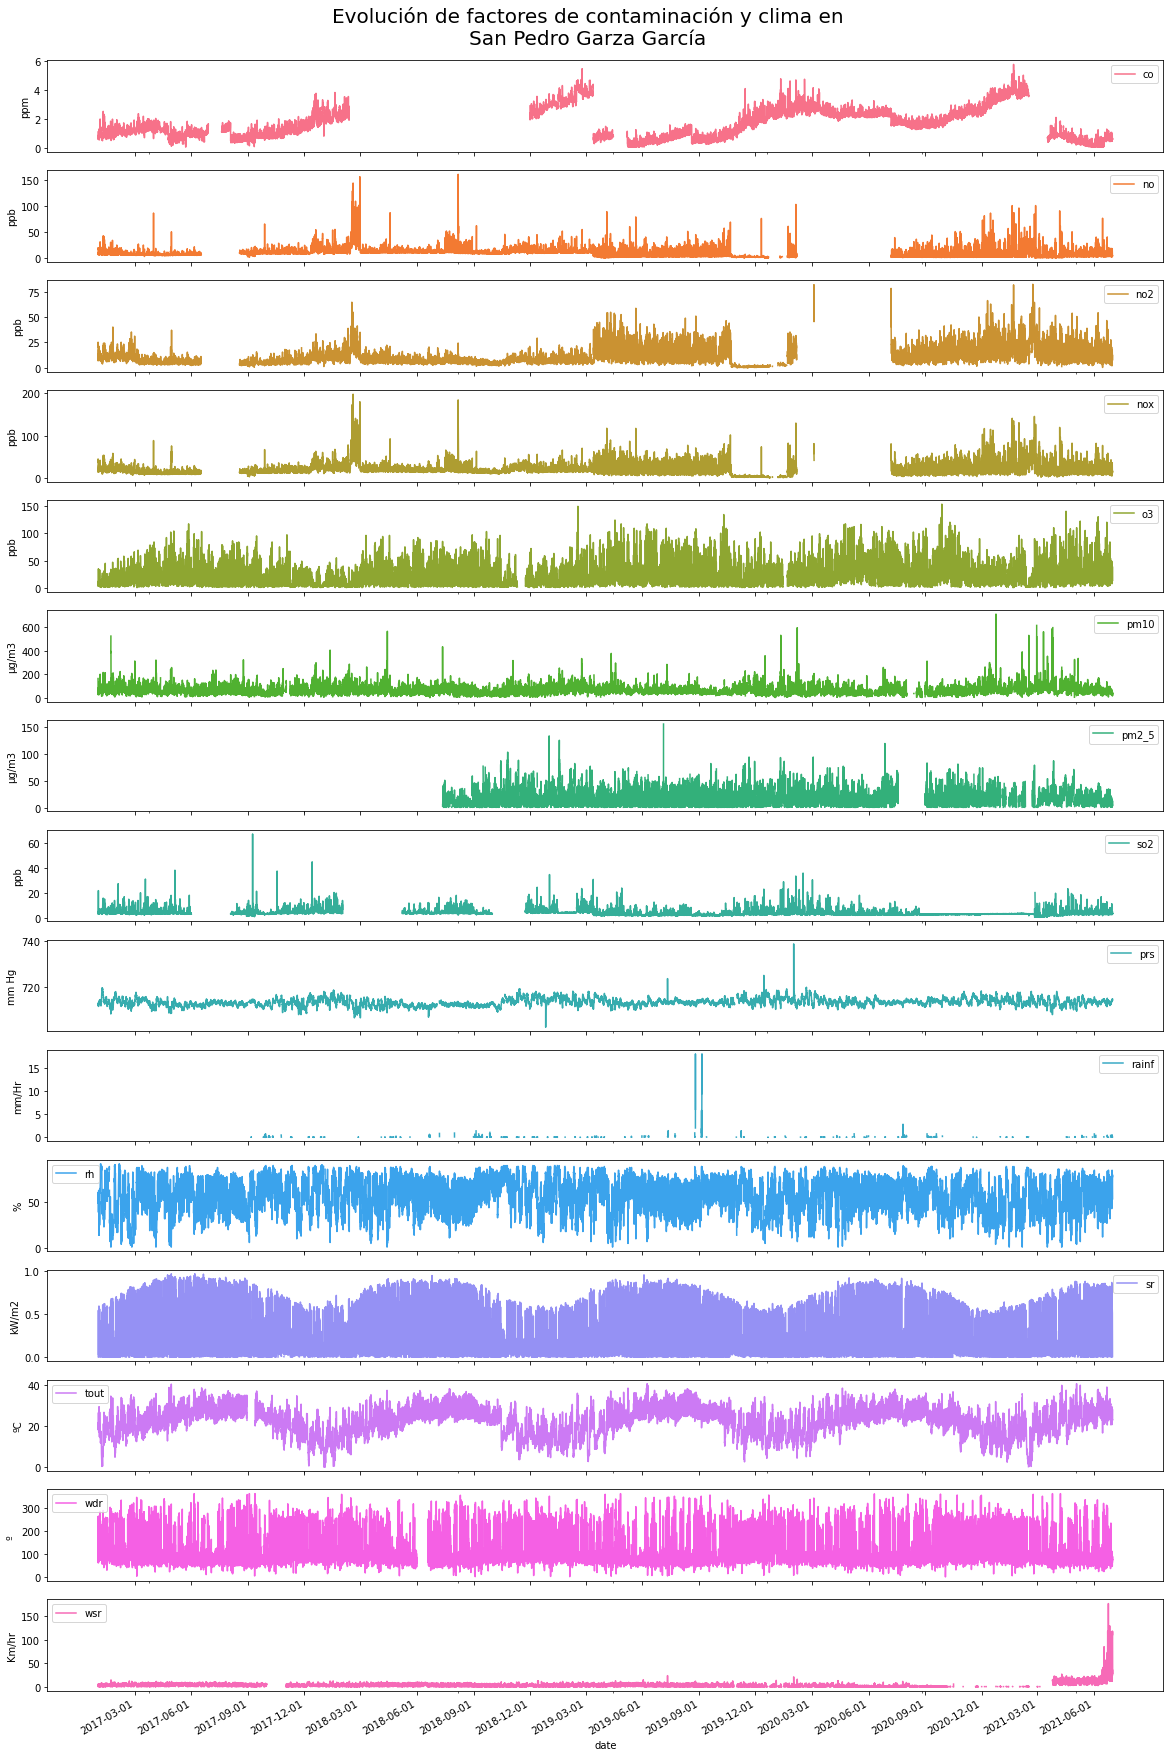

In [16]:
palette = sns.husl_palette(n_colors=15)

kwargs = {'subplots': True,
          'figsize': (20, 30),
          'sharex': True,
          'xticks': pd.date_range(sp.index.min(), sp.index.max(), freq='Q').strftime("%Y-%b").tolist(),
          'colormap': ListedColormap(palette.as_hex())
          }

axes = sp.plot(**kwargs)

for ax in axes:
    factor = ax.get_legend().get_texts()[0]._text
    ax.set_ylabel(measurement_units[factor])

fig = axes[0].get_figure()  # All Axes contain the 15 subplots as figure
fig.suptitle('Evolución de factores de contaminación y clima en\nSan Pedro Garza García',
             fontsize=20)
fig.subplots_adjust(top=0.955)


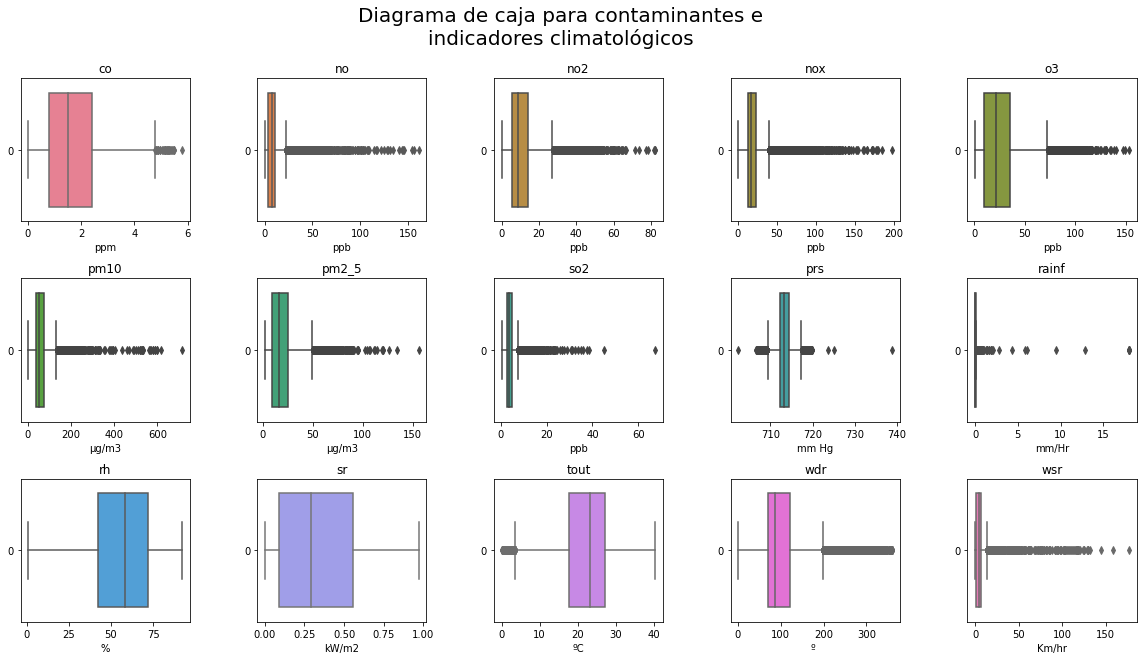

In [17]:
fig, axes = plt.subplots(3, 5, figsize=(20, 10),
                         gridspec_kw={'hspace': 0.4, 'wspace': 0.4})

iter_palette = iter(palette)

for i in range(3):
    for j in range(5):
        factor = sp.iloc[:, i*5 + j]
        sns.boxplot(data=factor, ax=axes[i, j],
                    orient='h', color=next(iter_palette))
        axes[i, j].set_title(factor.name)
        axes[i, j].set_xlabel(measurement_units[factor.name])
        

_ = fig.suptitle(
    'Diagrama de caja para contaminantes e\nindicadores climatológicos', fontsize=20)


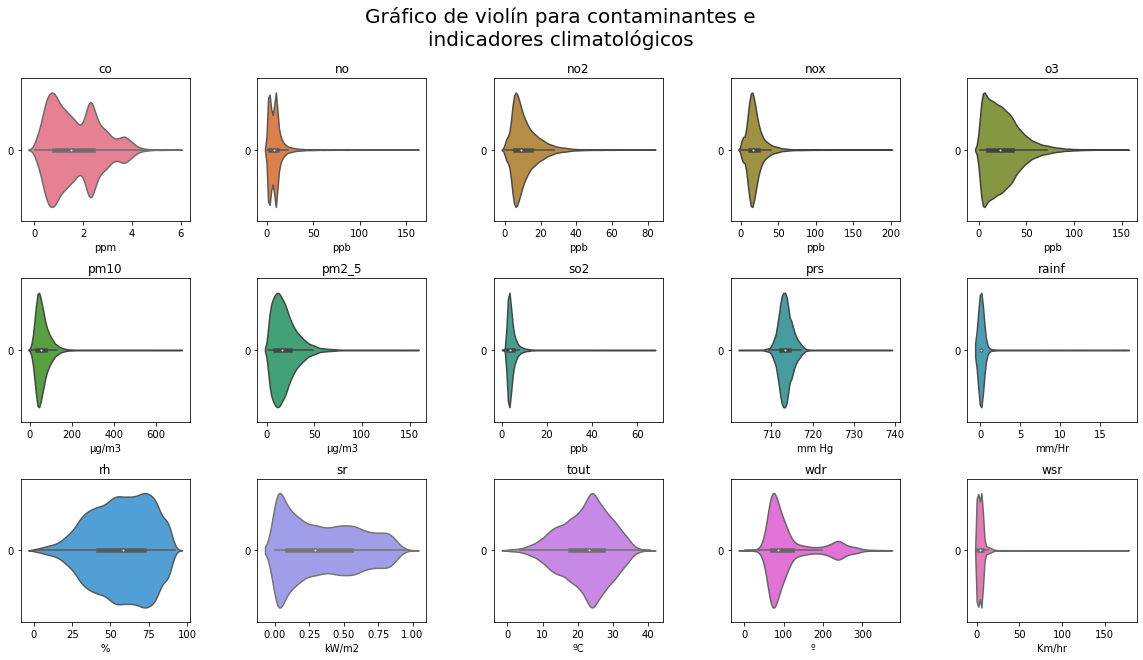

In [18]:
fig, axes = plt.subplots(3, 5, figsize=(20, 10),
                         gridspec_kw={'hspace': 0.4, 'wspace': 0.4})

iter_palette = iter(palette)

for i in range(3):
    for j in range(5):
        factor = sp.iloc[:, i*5 + j]
        sns.violinplot(data=factor, ax=axes[i, j], orient='h',
                       color=next(iter_palette))
        axes[i, j].set_title(factor.name)
        axes[i, j].set_xlabel(measurement_units[factor.name])

_ = fig.suptitle(
    'Gráfico de violín para contaminantes e\nindicadores climatológicos', fontsize=20)


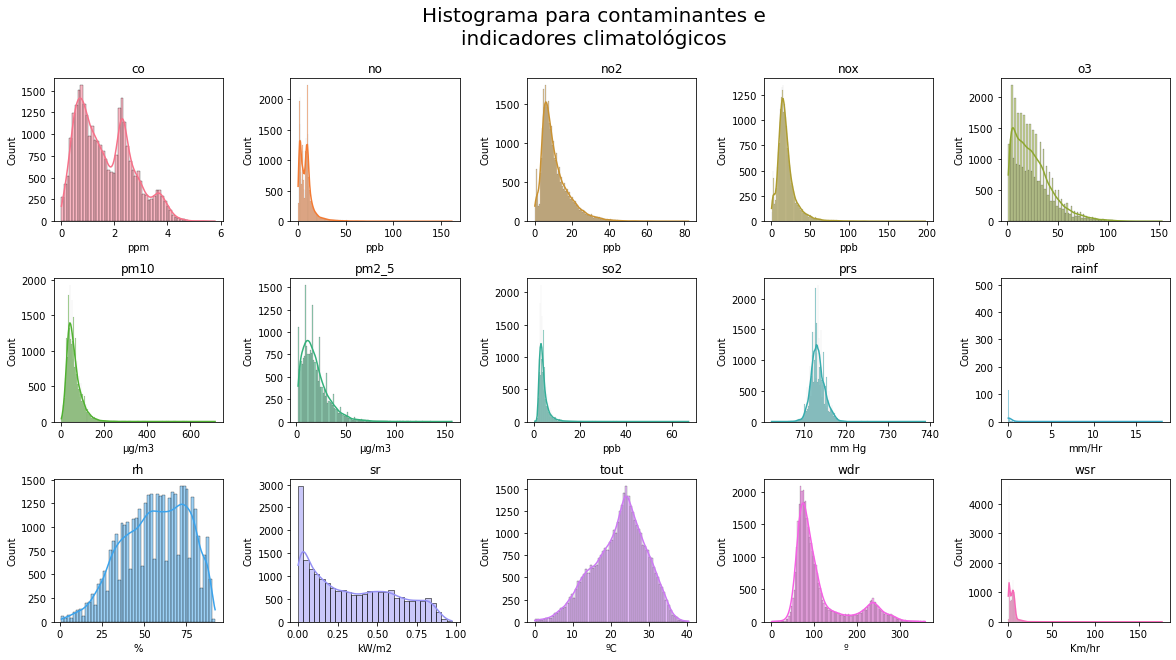

In [19]:
fig, axes = plt.subplots(3, 5, figsize=(20, 10),
                         gridspec_kw={'hspace': 0.4, 'wspace': 0.4})

iter_palette = iter(palette)

for i in range(3):
    for j in range(5):
        factor = sp.iloc[:, i*5 + j]
        sns.histplot(data=factor, ax=axes[i, j],
                     kde=True, color=next(iter_palette))
        axes[i, j].set_title(factor.name)
        axes[i, j].set_xlabel(measurement_units[factor.name])

_ = fig.suptitle(
    'Histograma para contaminantes e\nindicadores climatológicos', fontsize=20)


In [20]:
def plot_corr_ellipses(data, ax, **kwargs):

    m = np.array(data)
    xy = np.indices(m.shape)[::-1].reshape(2, -1).T
    w = np.ones_like(m).ravel()
    h = 1 - np.abs(m).ravel()
    a = 45 * np.sign(m).ravel()

    ec = EllipseCollection(widths=w, heights=h, angles=a, units='x', offsets=xy,
                           transOffset=ax.transData, array=m.ravel(), **kwargs)
    ax.add_collection(ec)

    if isinstance(data, pd.DataFrame):
        ax.set_xticks(np.arange(m.shape[1]))
        ax.set_xticklabels(data.columns, rotation=90)
        ax.set_yticks(np.arange(m.shape[0]))
        ax.set_yticklabels(data.index)

    return ec


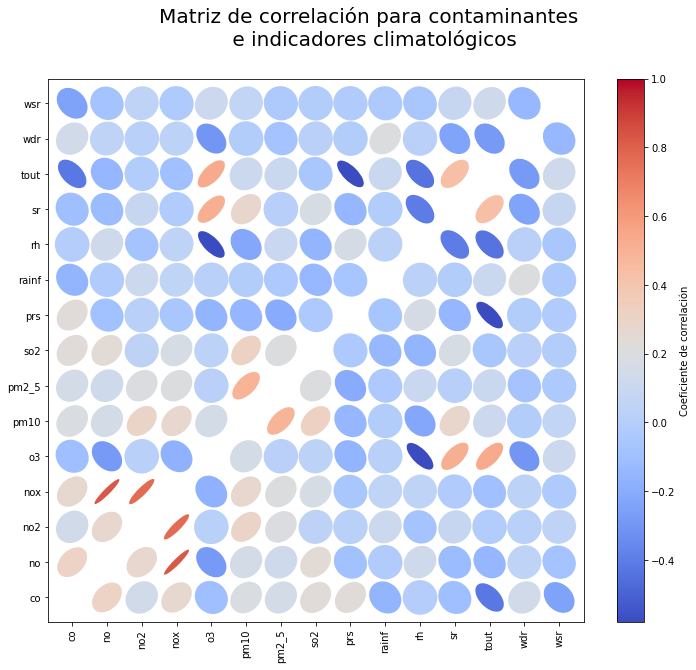

In [21]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.suptitle('Matriz de correlación para contaminantes \n e indicadores climatológicos',
             fontsize=20)
m = plot_corr_ellipses(sp.corr(), ax=ax, cmap='coolwarm')
cb = fig.colorbar(m)
cb.set_label('Coeficiente de correlación')
ax.margins(0.05)


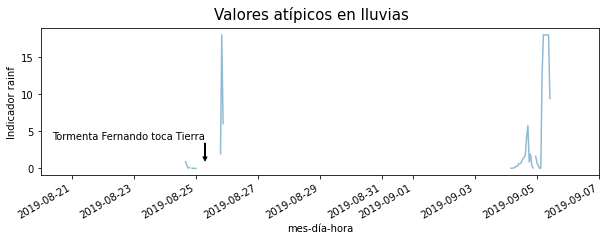

In [22]:
fig, ax = plt.subplots(figsize=(10, 3))
ax = sp.rainf.plot(color='#92BAD2')

# Zoom in September 2019
ax.set_xlim(['8-20-2019', '9-7-2019'])

occurence = {'date': datetime.datetime(2019, 8, 25, 7),
             'event': 'Tormenta Fernando toca Tierra'}
ax.annotate(occurence['event'], xy=(occurence['date'], sp.rainf.asof(occurence['date']) + 1),
            xytext=(occurence['date'],
                    sp.rainf.asof(occurence['date']) + 5),
            arrowprops=dict(facecolor='black', headwidth=4, width=1,
                            headlength=4),
            horizontalalignment='right', verticalalignment='top')

ax.set_xlabel('mes-día-hora')
ax.set_ylabel('Indicador rainf')
_ = fig.suptitle('Valores atípicos en lluvias', fontsize=15)


Los valores atípicos fueron causados por una tormenta, se revisará si esta tuvo un impacto severo en las demás variables, si no es el caos, se eliminarán estos valores expremos y se  reemplazaron los valores faltantes con cero. 

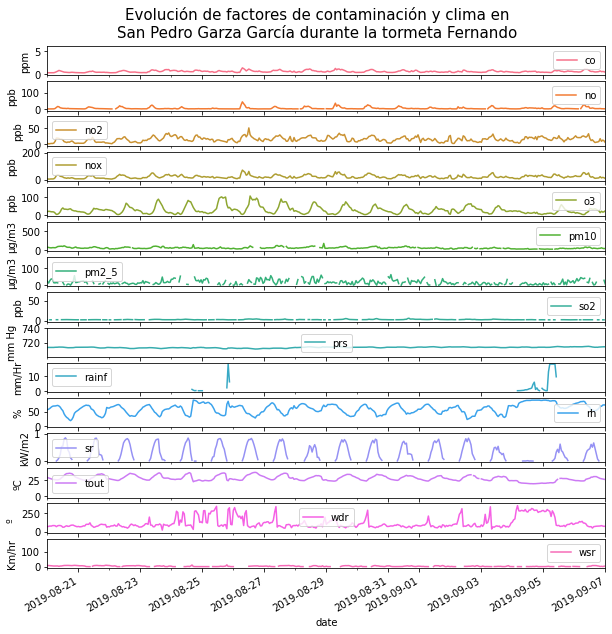

In [23]:
palette = sns.husl_palette(n_colors=15)

kwargs = {'subplots': True,
          'figsize': (10, 10),
          'sharex': True,
          'xlim': ['8-20-2019', '9-7-2019'],
          'colormap': ListedColormap(palette.as_hex())
          }

axes = sp.plot(**kwargs)

for ax in axes:
    factor = ax.get_legend().get_texts()[0]._text
    ax.set_ylabel(measurement_units[factor])

fig = axes[0].get_figure()  # All Axes contain the 15 subplots as figure
fig.suptitle(
    'Evolución de factores de contaminación y clima en\nSan Pedro Garza García durante la tormeta Fernando', fontsize=15)
fig.subplots_adjust(top=0.925)


No hubo una alza en los contaminantes ni en otros factores meteorológicos, es seguro eliminar estos valores atípicos y proceder con un método general para las demás variables

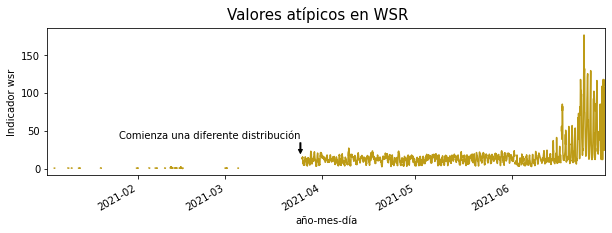

In [24]:
fig, ax = plt.subplots(figsize=(10, 3))
ax = sp.wsr.plot(color='#BD9B16')

# Zoom in april 2021
ax.set_xlim(['1-3-2021', sp.index.max()])

occurence = {'date': datetime.datetime(2021, 3, 25, 4),
             'event': 'Comienza una diferente distribución'}

ax.annotate(occurence['event'], xy=(occurence['date'], sp.rainf.asof(occurence['date']) + 20),
            xytext=(occurence['date'],
                    sp.rainf.asof(occurence['date']) + 50),
            arrowprops=dict(facecolor='black', headwidth=4, width=1,
                            headlength=4),
            horizontalalignment='right', verticalalignment='top')

ax.set_xlabel('año-mes-día')
ax.set_ylabel('Indicador wsr')
_ = fig.suptitle('Valores atípicos en WSR', fontsize=15)


Se desconoce el porqué de esta diferencia en la toma de datos, se cree que ocurrió alguna falla técnica dentro del sensor, ya que las mediciones no se asemejan de ninguna manera a lo recabado en los años anteriores. Se eliminarán los valores a partir de esta fecha, debido a la alta incertidumbre que se tiene.

In [25]:
# Subset where there is minimum of missing data in San Pedro.
# One year of data from 2019 to 2020.

sp = sp.loc[(sp.index > '2019-06-01') &
            (sp.index < '2020-06-01'), :]


# Transformación

### Outlier elimination

In [26]:
sp = (
      sp
      .pipe(janitor.transform_column, column_name='rainf',
            function=lambda rainf: rainf.where(
                  (rainf.index < '2019-8-25') | (rainf.index > '2019-9-6'), np.nan),
            elementwise=False)
      .pipe(janitor.transform_column, column_name='wsr',
            function=lambda wsr: wsr.where(wsr.index < '2021-3-23', np.nan),
            elementwise=False)
)


In [27]:
limits = pd.Series({
    'co': 26,
    'no': 210,
    'no2': 210,
    'nox': 210,
    'o3': 90,
    'pm10': 70,
    'pm2_5': 41,
    'so2': 75,
    'prs': 760,
    'rainf': 130,
    'rh': 100,
    'sr': 1,
    'tout': 45,
    'wdr': 360,
    'wsr': 117,
}) # Maximum value that variables can take according to the Mexican normatives of air quality

sp = sp.apply(lambda row: row.where(row < limits, np.nan), axis=1)

### Imputation

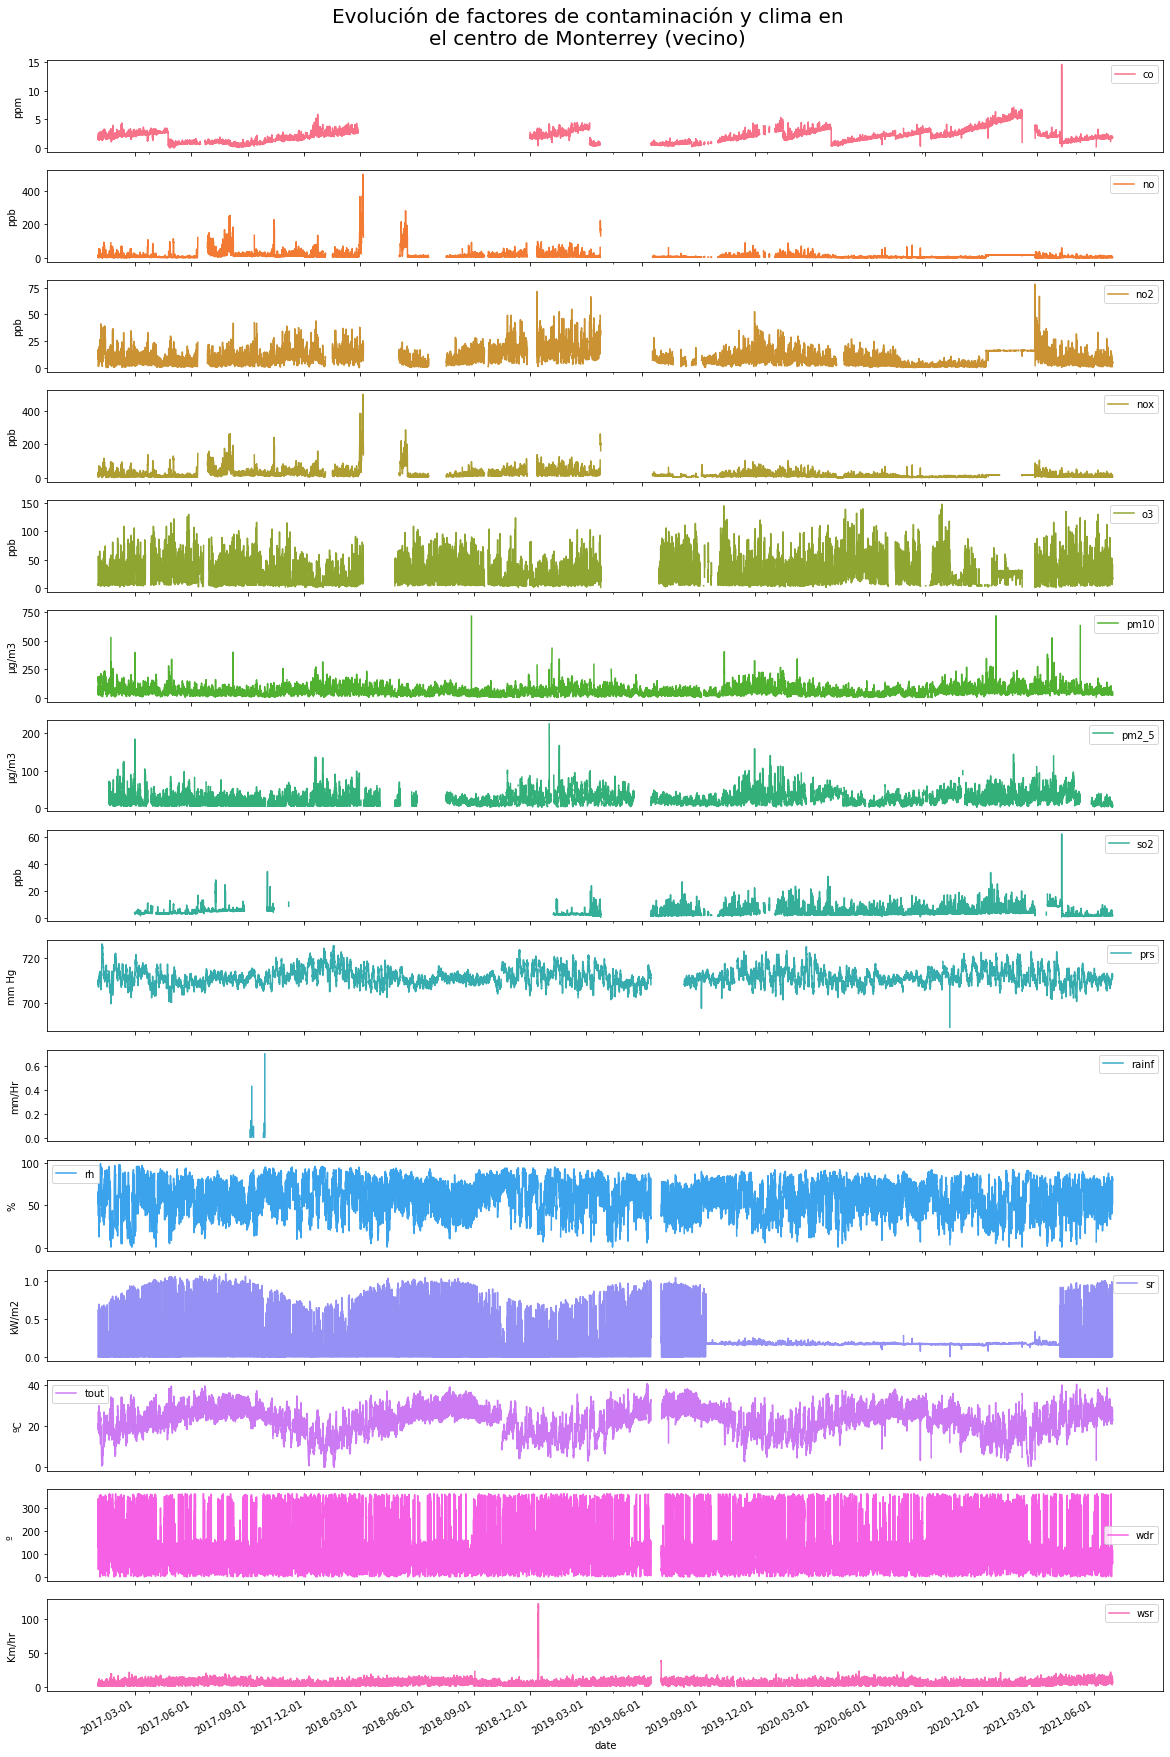

In [28]:
palette = sns.husl_palette(n_colors=15)

kwargs = {'subplots': True,
          'figsize': (20, 30),
          'sharex': True,
          'xticks': pd.date_range(centro.index.min(), centro.index.max(), freq='Q').strftime("%Y-%b").tolist(),
          'colormap': ListedColormap(palette.as_hex())
          }

axes = centro.plot(**kwargs)

for ax in axes:
    factor = ax.get_legend().get_texts()[0]._text
    ax.set_ylabel(measurement_units[factor])

fig = axes[0].get_figure()  # All Axes contain the 15 subplots as figure
_ = fig.suptitle(
    'Evolución de factores de contaminación y clima en\nel centro de Monterrey (vecino)', fontsize=20)
fig.subplots_adjust(top=0.955)


In [29]:
centro = centro.apply(lambda row: row.where(row < limits, np.nan), axis=1)

In [30]:
# Imputate missing values from centro

sp = (
    sp
    .pipe(janitor.fill_empty, column_names='no', value=centro.no)
    .pipe(janitor.fill_empty, column_names='no2', value=centro.no2)
    .pipe(janitor.fill_empty, column_names='nox', value=centro.nox)
    .pipe(janitor.fill_empty, column_names='rainf', value=0) # There was no rain
)

# Rolling statistic and first days with mean

sp = (
    sp
    .fillna(sp.rolling(24*7*12, min_periods=1, closed='both').mean())
    .fillna(sp.mean())
)

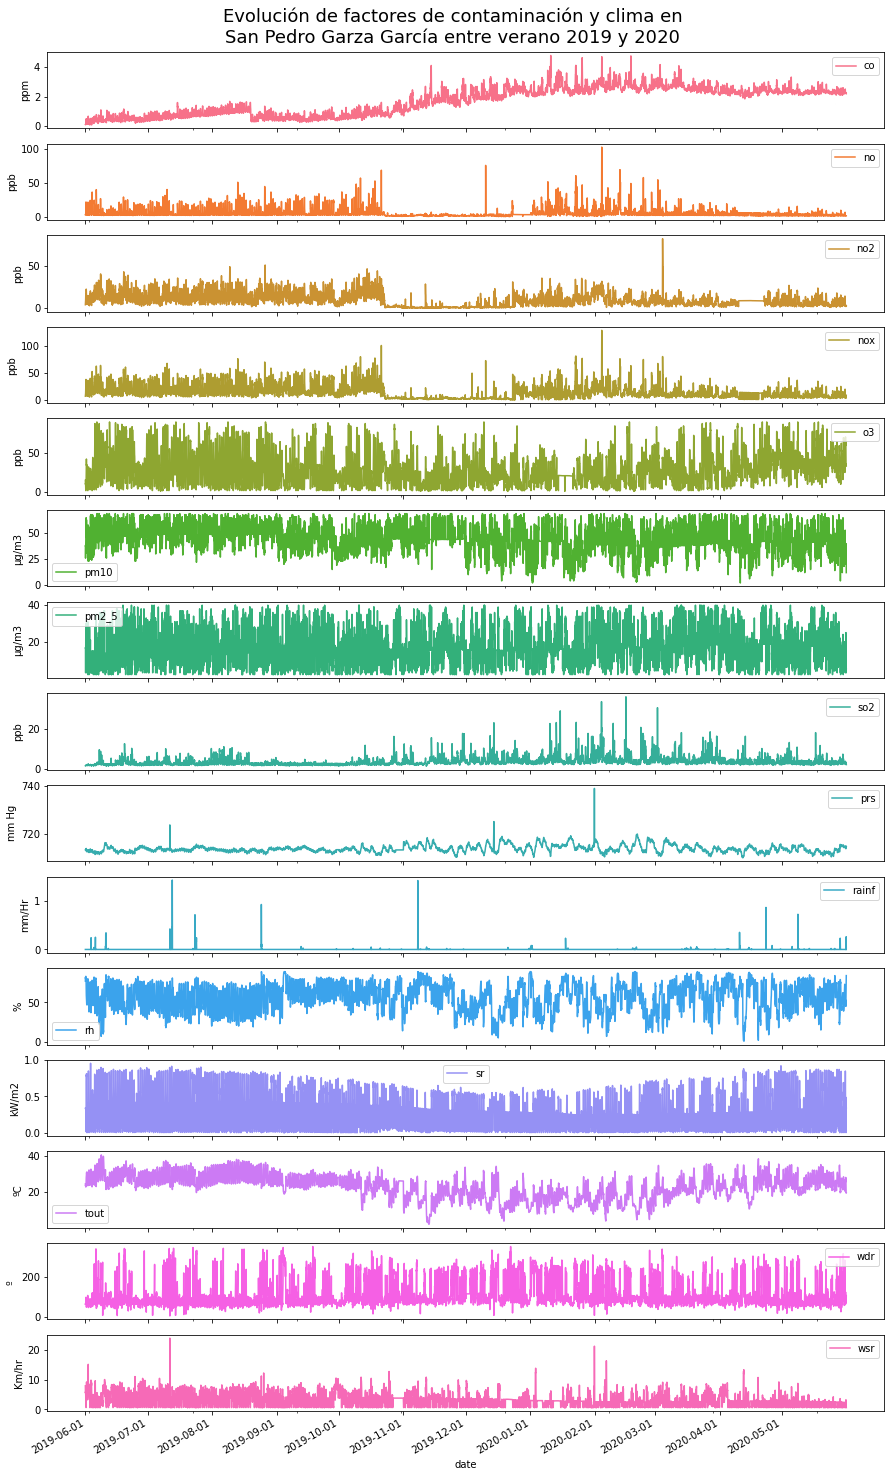

In [31]:
palette = sns.husl_palette(n_colors=15)

kwargs = {'subplots': True,
          'figsize': (15, 25),
          'sharex': True,
          'xticks': pd.date_range(sp.index.min(), sp.index.max(), freq='M').strftime("%Y-%b").tolist(),
          'colormap': ListedColormap(palette.as_hex())
          }

axes = sp.plot(**kwargs)

for ax in axes:
    factor = ax.get_legend().get_texts()[0]._text
    ax.set_ylabel(measurement_units[factor])

fig = axes[0].get_figure()  # All Axes contain the 15 subplots as figure
_ = fig.suptitle(
    'Evolución de factores de contaminación y clima en\nSan Pedro Garza García entre verano 2019 y 2020', fontsize=18)
fig.subplots_adjust(top=0.955)


# Modelación

In [32]:
scaler = StandardScaler()

scaled_df = pd.DataFrame(scaler.fit_transform(sp),
                         columns=sp.columns,
                         index=sp.index)


In [33]:
def pca_plot(df: pd.core.frame.DataFrame):

    pca = PCA()
    pca.fit(df)

    loadings = pd.DataFrame(pca.components_, columns=df.columns)
    explained_variance = pd.DataFrame(pca.explained_variance_)

    fig, ax = plt.subplots(figsize=(10, 4))
    ax = explained_variance.plot.bar(legend=False, ax=ax,
                                     color='#BEBEBE', edgecolor='black',
                                     width=0.75)
    ax.set_xticklabels(('Comp. ' + str(f) for f in range(1, 16)))
    ax.set_ylabel('Varianza')
    fig.suptitle('Varianza de componentes', fontsize=15)

    return pca


def screeplot(pca: PCA()):
    fig, ax = plt.subplots(figsize=(10, 4))

    ax.plot(pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')

    ax.set_xticks(range(15))
    ax.set_xticklabels(range(1, 16))

    ax.axvline(4, linestyle='--', color='#F47174',
               ymax=pca.explained_variance_ratio_[4]/pca.explained_variance_ratio_[0])
    ax.annotate(f'$\sigma^2={pca.explained_variance_ratio_.cumsum()[4]:0.2f}$',
                xy=(4+0.15, pca.explained_variance_ratio_[4]+0.01))

    ax.set_xlabel('Componente')
    ax.set_ylabel('Varianza explicada (porcentual)')

    fig.suptitle('Gráfica de codo para Componentes Principales', fontsize=18)


def pca_loadings_plot(df: pd.core.frame.DataFrame, n_components=5):

    pca = PCA()
    pca.fit(df)

    loadings = pd.DataFrame(pca.components_[:n_components, :],
                            columns=df.columns)

    fig, axes = plt.subplots(n_components, 1, figsize=(12, 10),
                             sharex=True)
    for i, ax in enumerate(axes):
        pc_loadings = loadings.loc[i, :]
        colors = ['#56BDC2' if l > 0 else '#E77E72' for l in pc_loadings]
        pc_loadings.plot.bar(ax=ax, color=colors)
        ax.set_ylabel(f'PC{i+1}', fontsize=12)
        ax.yaxis.set_label_position('right')
        ax.set_xlabel(None)
        ax.set_axisbelow(True)
        ax.grid()

    fig.suptitle(f'Cargas para los {n_components} Componentes Principales\ncon mayor varianza',
                 fontsize=15)
    fig.subplots_adjust(top=0.925)


def fa_linear_combinations(df: pd.core.frame.DataFrame, n_components=15):

    factor_analysis = FactorAnalysis(n_components=n_components)
    factor_analysis.fit_transform(df)
  
    factors = pd.DataFrame(factor_analysis.components_, columns=df.columns).T

    print("Explained variance")
    print((factors*factors).sum() / (factors*factors).sum().sum())

    return factors

def fa_loadings_plot(df: pd.core.frame.DataFrame, n_components=3):

    fa = FactorAnalysis()
    fa.fit(df)

    loadings = pd.DataFrame(fa.components_[:n_components, :],
                            columns=df.columns)

    fig, axes = plt.subplots(n_components, 1, figsize=(12, 10),
                             sharex=True)
    for i, ax in enumerate(axes):
        pc_loadings = loadings.loc[i, :]
        colors = ['#5F4B8BFF' if l > 0 else '#E69A8DFF' for l in pc_loadings]
        pc_loadings.plot.bar(ax=ax, color=colors)
        ax.set_ylabel(f'FA{i+1}', fontsize=12)
        ax.yaxis.set_label_position('right')
        ax.set_xlabel(None)
        ax.set_axisbelow(True)
        ax.grid()

    fig.suptitle(f'Factores con mayor varianza ({n_components}) para la serie de tiempo',
                 fontsize=15)
    fig.subplots_adjust(top=0.925)

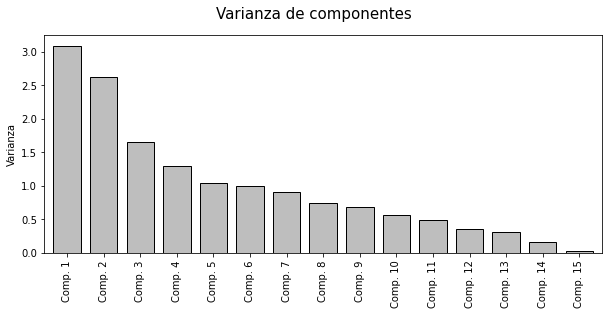

In [34]:
pca = pca_plot(df=scaled_df)

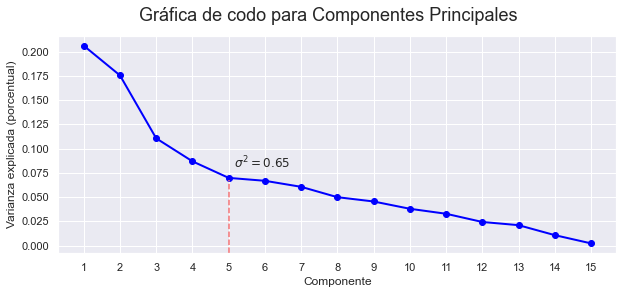

In [35]:
sns.set()
screeplot(pca)

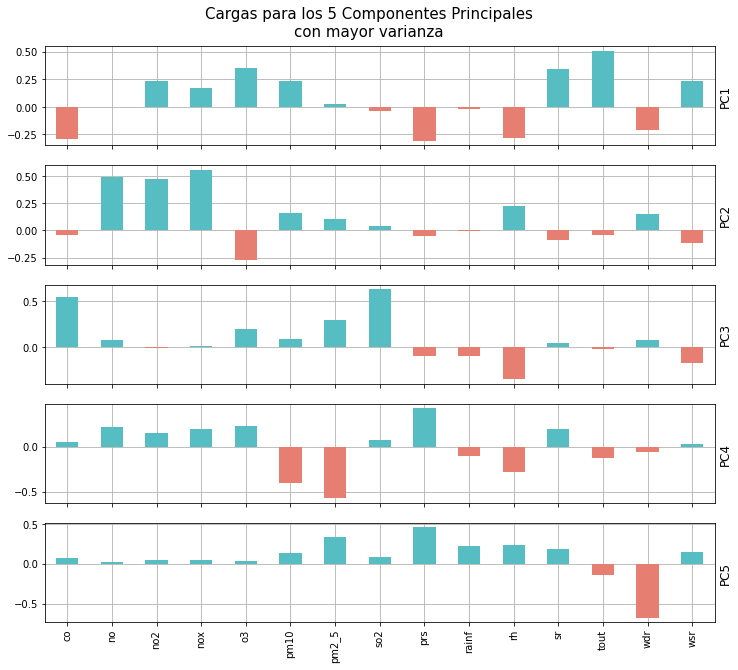

In [36]:
sns.reset_orig()
pca_loadings_plot(scaled_df)

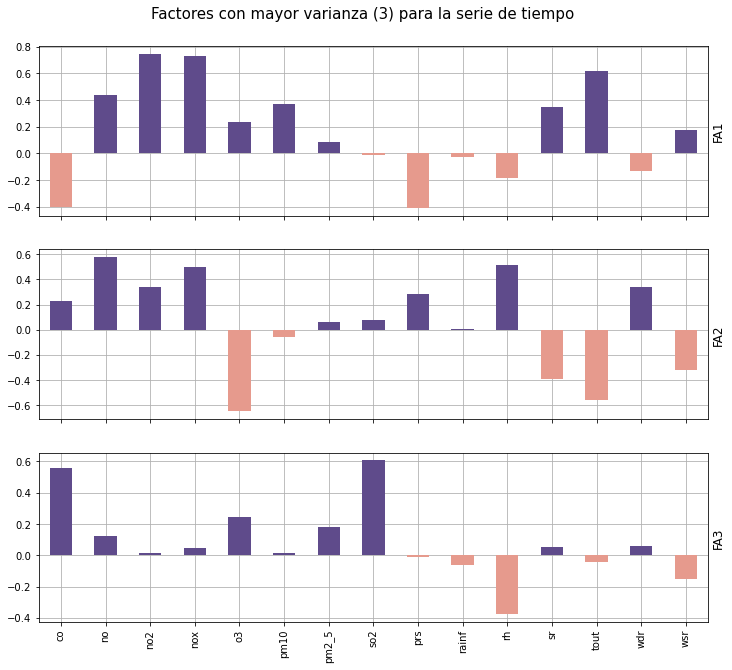

In [37]:
fa_loadings_plot(df=scaled_df)

# Hourly

In [38]:
factors = fa_linear_combinations(scaled_df)

Explained variance
0     0.360156
1     0.335046
2     0.146030
3     0.089177
4     0.040617
5     0.020854
6     0.007632
7     0.000488
8     0.000000
9     0.000000
10    0.000000
11    0.000000
12    0.000000
13    0.000000
14    0.000000
dtype: float64


In [39]:
factors.loc[:, :2]

,0,1,2
factor,,,
co,-0.399090,0.225420,0.557878
no,0.435944,0.576862,0.122780
no2,0.745819,0.342450,0.016867
nox,0.728202,0.499859,0.047836
o3,0.237735,-0.648800,0.241328
pm10,0.369330,-0.056317,0.016701
pm2_5,0.087143,0.064782,0.182414
so2,-0.011775,0.079844,0.605109
prs,-0.407684,0.286661,-0.014206


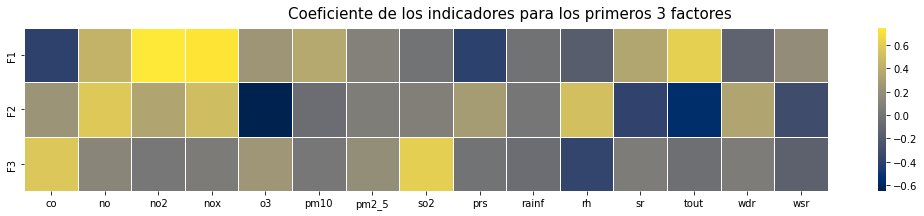

In [40]:
fig, ax = plt.subplots(figsize=(18, 3))

sns.heatmap(factors.loc[:, :2].T, cmap='cividis',
            linewidths=0.5, ax=ax, yticklabels=['F1', 'F2', 'F3'])

ax.set_xlabel(None)
_ = fig.suptitle('Coeficiente de los indicadores para los primeros 3 factores', fontsize=15)

In [41]:

lc = pd.DataFrame(FactorAnalysis(n_components=15).fit_transform(scaled_df),
                  index=scaled_df.index)
# General NO, actividad de coches durante la jornada laboral Día
# Frío y Noche, incrementan moléculas y baja ozono
# CO y SO2, general


In [42]:
exclude_holidays = ['2019-01-01', '2020-01-01',
                    '2019-02-07', '2020-07-02',
                    '2019-05-01', '2020-05-01',
                    '2019-09-16', '2020-09-16',
                    '2019-11-21', '2020-11-21',
                    '2019-12-25', '2020-12-25']

cbh_labor = pd.tseries.offsets.CustomBusinessHour(start="05:00", end="18:00",
                                                  weekmask='1111100',
                                                  holidays=exclude_holidays)

business_timestamps = pd.date_range(start=sp.index.min(), end=sp.index.max(),
                                    freq=cbh_labor)


In [43]:
sp_ = (
    sp
    .pipe(janitor.add_columns, 
          labor_activity=sp.index.isin(business_timestamps))
)

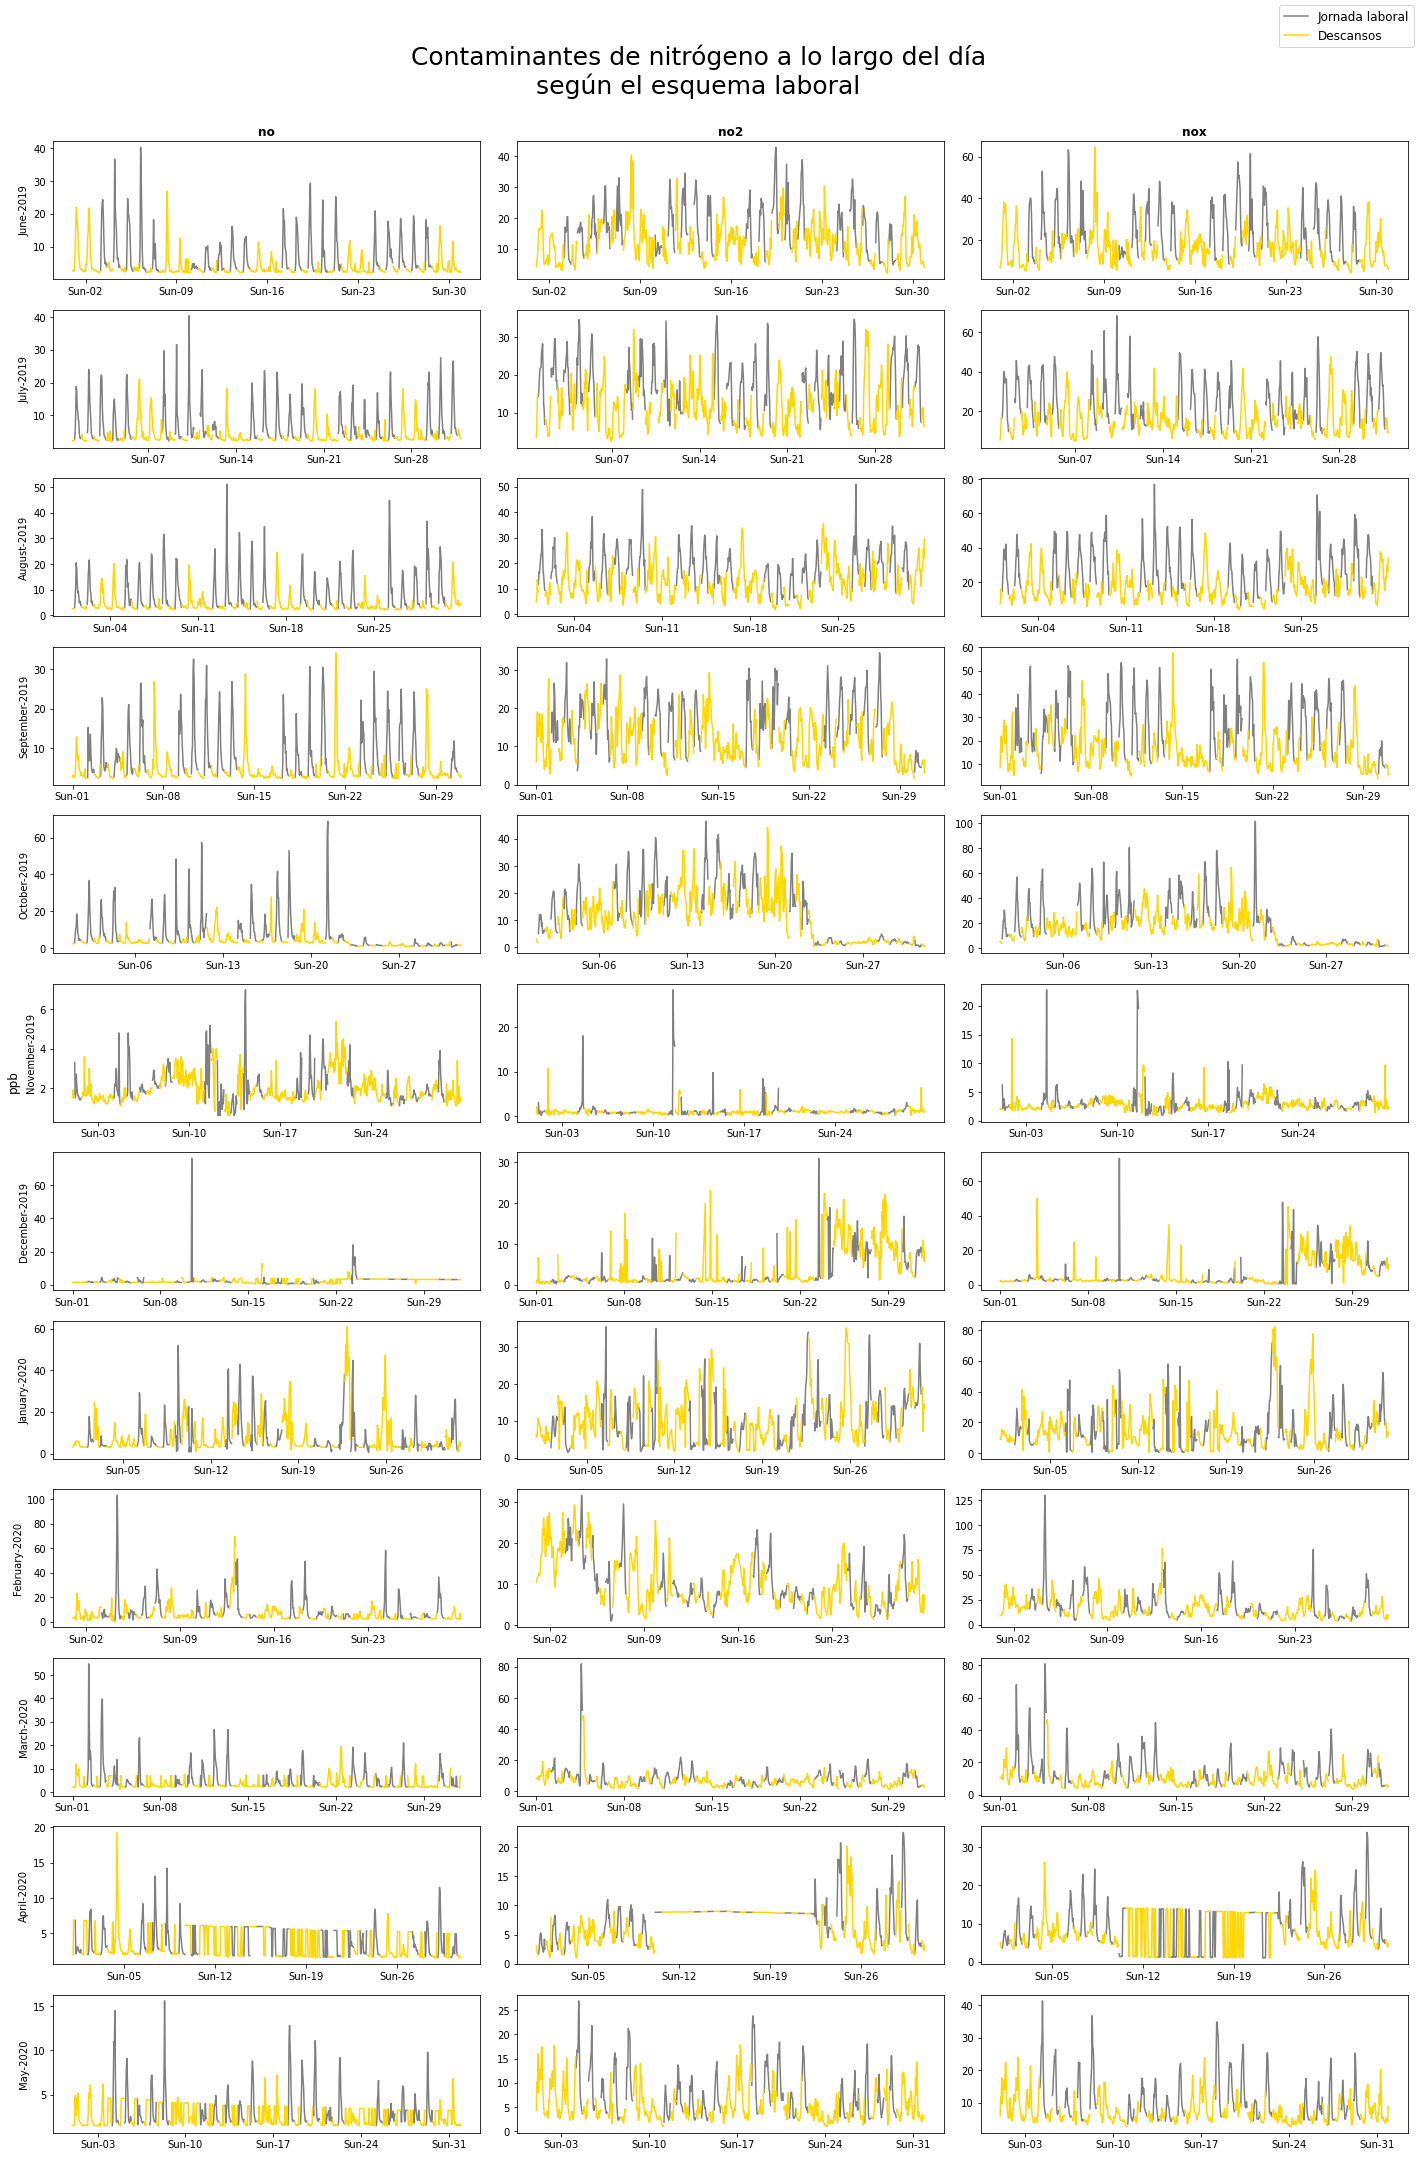

In [44]:
fig, axes = plt.subplots(12, 3, figsize=(20, 30))
nitrogens = ['no', 'no2', 'nox']

labor = sp_.copy()
non_labor = sp_.copy()
labor[~labor.labor_activity] = np.nan
non_labor[non_labor.labor_activity] = np.nan

for i in range(12):
    
    for j, nitrogen in enumerate(nitrogens):
        month = ((i + 5) % 12) + 1 
        labor_data = labor.loc[(labor.index.month == month), nitrogen]
        non_labor_data = non_labor.loc[(non_labor.index.month == month), nitrogen]


        axes[i, j].plot(labor_data, c='gray', label='Jornada laboral')
        axes[i, j].plot(non_labor_data, c='gold', label='Descansos')

        xticks_ = pd.date_range(start=labor_data.index.min(),
                                end=labor_data.index.max(),
                                freq='W')

        axes[i, j].set_xticks(xticks_)
        axes[i, j].set_xticklabels(xticks_.strftime('%a-%d'))
        if i == 0:
            axes[i, j].set_title(nitrogen, fontweight='bold')
        if j == 0:
            axes[i, j].set_ylabel(labor_data.index.min().strftime('%B-%Y'), fontsize=10)
    
handles, labels = axes[i, j].get_legend_handles_labels()
fig.legend(handles, labels, prop={'size': 12})

fig.supylabel('ppb')
fig.suptitle('Contaminantes de nitrógeno a lo largo del día\nsegún el esquema laboral', fontsize=25)
fig.tight_layout()
fig.subplots_adjust(top=0.935)

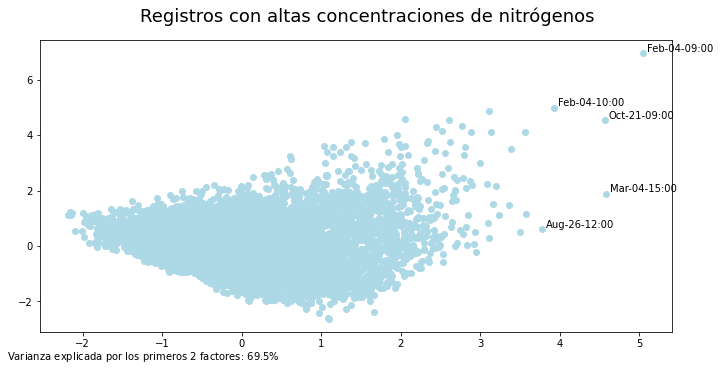

In [45]:
factor_analysis = FactorAnalysis(n_components=15)
lc = pd.DataFrame(factor_analysis.fit_transform(scaled_df),
                  index=scaled_df.index)

fig, ax = plt.subplots(figsize=(10, 5))

ax.scatter(x=lc[0], y=lc[1], c='#ADD8E6')

for k, v in lc.loc[lc.iloc[:, 0] > 3.6, 0:1].iterrows():
    ax.annotate(k.strftime('%b-%d-%H:00'), v+0.05)

fig.suptitle('Registros con altas concentraciones de nitrógenos', fontsize=18)
fig.tight_layout()
_ = fig.text(0, 0, s='Varianza explicada por los primeros 2 factores: $69.5\%$')


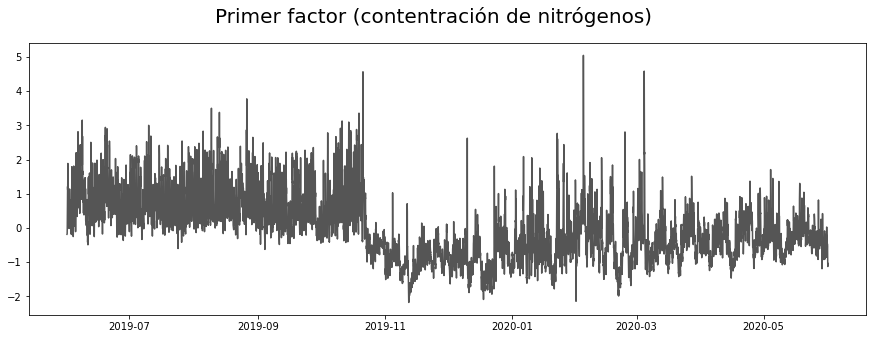

In [46]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(lc.index, lc.iloc[:, 0], c='#555555')
_ = fig.suptitle('Primer factor (contentración de nitrógenos)', fontsize=20)


# Daily

In [47]:
daily_scaled_df = scaled_df.groupby(pd.Grouper(freq='d')).mean()
factors = fa_linear_combinations(daily_scaled_df)


Explained variance
0     0.570326
1     0.174475
2     0.159423
3     0.069070
4     0.020622
5     0.006084
6     0.000000
7     0.000000
8     0.000000
9     0.000000
10    0.000000
11    0.000000
12    0.000000
13    0.000000
14    0.000000
dtype: float64


In [48]:
factors.loc[:, [0, 1, 2]]


,0,1,2
factor,,,
co,0.673822,0.312170,-0.253735
no,-0.117070,0.248720,0.182834
no2,-0.472418,0.288631,0.209145
nox,-0.394662,0.292176,0.223436
o3,-0.186640,-0.098172,-0.178145
pm10,-0.321744,0.100336,-0.137871
pm2_5,-0.040486,0.227801,-0.109882
so2,0.217333,0.310563,-0.202165
prs,0.491272,-0.202162,0.309159


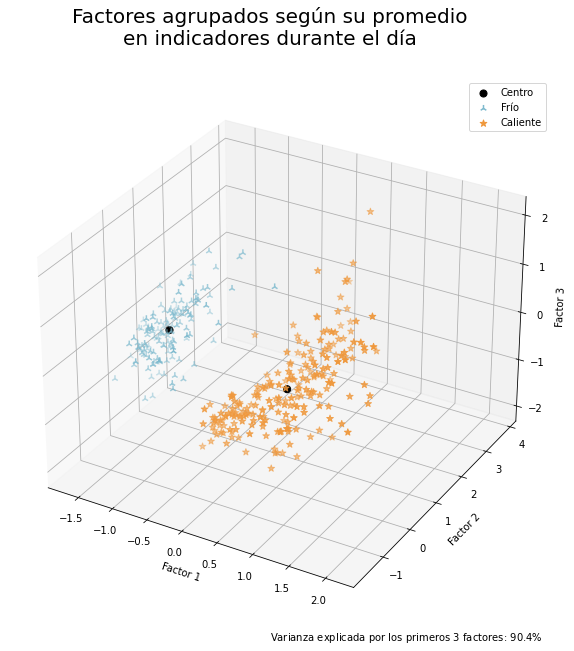

In [49]:

lc = pd.DataFrame(FactorAnalysis(n_components=15).fit_transform(daily_scaled_df),
                  index=daily_scaled_df.index).loc[:, [0, 1, 2]]

# Clustering

kmeans = KMeans(n_clusters=2).fit(lc)
labels = kmeans.predict(lc)
centroids = kmeans.cluster_centers_

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

is_cold = np.array(labels == 0)
is_hot = np.array(labels == 1)

ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2],
           c='black', s=50, label="Centro", alpha=1)

ax.scatter(lc.loc[is_cold, 0], lc.loc[is_cold, 1], lc.loc[is_cold, 2],
           c='#7EBACE', s=50, label='Frío', marker='2')
ax.scatter(lc.loc[is_hot, 0], lc.loc[is_hot, 1], lc.loc[is_hot, 2],
           c='#Ef983C', s=50, label='Caliente', marker='*')

ax.set_xlabel('Factor 1')
ax.set_ylabel('Factor 2')
ax.set_zlabel('Factor 3')
ax.legend()

fig.suptitle(
    'Factores agrupados según su promedio\nen indicadores durante el día', fontsize=20)
_ = fig.text(
    0.5, 0.1, s='Varianza explicada por los primeros 3 factores: $90.4\%$')


# Monthly

In [50]:
monthly_scaled_df = scaled_df.groupby(pd.Grouper(freq='M')).mean()
factors = fa_linear_combinations(monthly_scaled_df)


Explained variance
0     0.593441
1     0.225906
2     0.108882
3     0.037265
4     0.019724
5     0.006004
6     0.003770
7     0.002280
8     0.001868
9     0.000859
10    0.000000
11    0.000000
dtype: float64


In [51]:
factors.loc[:, [0, 1]]
# Mes de frío (nuevamente, coeficientes similares)
# Mes de calor
# Average


,0,1
factor,,
co,0.758565,0.424508
no,-0.188679,0.242812
no2,-0.542368,0.133258
nox,-0.464455,0.171714
o3,-0.113431,-0.110803
pm10,-0.200175,-0.206711
pm2_5,0.020553,0.048792
so2,0.272082,0.238587
prs,0.234562,0.258299


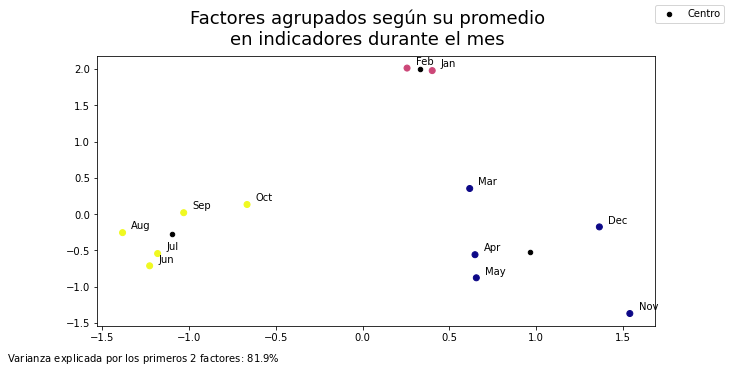

In [52]:
factor_analysis = FactorAnalysis(n_components=15)
lc = pd.DataFrame(factor_analysis.fit_transform(monthly_scaled_df),
                  index=monthly_scaled_df.index).loc[:, [0, 1]]

# Clustering

kmeans = KMeans(n_clusters=3).fit(lc)
labels = kmeans.predict(lc)
centroids = kmeans.cluster_centers_

fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(centroids[:, 0], centroids[:, 1],
           c="black", s=20, label="Centro", alpha=1)

for k, v in lc.iterrows():
    ax.annotate(k.strftime('%b'), v+0.05)

ax.scatter(x=lc[0], y=lc[1], c=labels, cmap='plasma')

fig.suptitle('Factores agrupados según su promedio\nen indicadores durante el mes', fontsize=18)
#fig.tight_layout()
fig.subplots_adjust(top=0.85, bottom=0.1)
fig.legend()
_ = fig.text(0, 0, s='Varianza explicada por los primeros 2 factores: $81.9\%$')

In [53]:
sp.tout.groupby(pd.Grouper(freq='M')).mean().sort_values()


date
2020-01-31    16.277099
2020-02-29    16.400734
2019-12-31    16.878079
2019-11-30    17.696990
2020-03-31    22.331716
2019-10-31    23.552449
2020-04-30    24.041086
2020-05-31    25.819960
2019-09-30    26.219366
2019-07-31    28.444045
2019-06-30    28.520730
2019-08-31    29.727411
Name: tout, dtype: float64

La temperatura promedio durante cada mes sigue un orden casi idéntico al señalado por las conglomeraciones